In [8]:
# Install imbalanced-learn if missing
!pip install -q imbalanced-learn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report,
    roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
)
from sklearn.preprocessing import label_binarize
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import seaborn as sns
import time
import pickle
import warnings
warnings.filterwarnings("ignore")

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
print(os.listdir('/content/drive/MyDrive/idsprojectcsvs'))

['02-15-2018.csv', '02-21-2018.csv', '02-22-2018.csv', '03-01-2018.csv', '02-28-2018.csv', '02-16-2018.csv', '03-02-2018.csv', '02-14-2018.csv']


In [4]:
folder_path = '/content/drive/MyDrive/idsprojectcsvs'
dfs = {}

for fname in os.listdir(folder_path):
    if fname.endswith('.csv'):
        path = os.path.join(folder_path, fname)
        dfs[fname] = pd.read_csv(path)

In [5]:
#  My Full training pipeline using stratified split, SMOTE, tuning, ROC/F1/confusion matrix


# PARAMETERS / SAFEGUARDS

RANDOM_STATE = 42
TEST_SIZE = 0.20   # final held-out fraction from the "train_set" after split into train/val (doing train/val/test)
VAL_SIZE = 0.20    # validation fraction (of training portion)
MAX_TRAIN_ROWS = 100_000
SMOTE_K = 5                 # k_neighbors for SMOTE
N_RANDOM_SEARCH = 5        # hyperparam search iterations for RandomForest
N_JOBS = -1                 # parallel jobs


# 1. training dataframe (FIXED)

train_days = [
    '02-14-2018.csv',
    '02-15-2018.csv',
    '02-16-2018.csv',
    '02-21-2018.csv',
    '02-22-2018.csv'
]

print(f"Concatenating {len(train_days)} days from your 'dfs' dictionary...")
train_df = pd.concat([dfs[d] for d in train_days], ignore_index=True)
print("Raw train_df shape:", train_df.shape)

# 2. cleaning and normalizing all columns ....

print("Cleaning column names...")
train_df.columns = train_df.columns.str.strip().str.lower().str.replace(' ', '_')

# Debug print to prove it exists now
print("Columns found:", list(train_df.columns[:5]), "... and ...", list(train_df.columns[-5:]))

# 3. Check if label exists now
if 'label' not in train_df.columns:
    # Fallback: sometimes it's called 'label_str' or something else
    print("ERROR: Still can't find 'label'. Available columns:", train_df.columns)
else:
    print("Column 'label' found successfully!")

# Label encode consistently
le = LabelEncoder()
# Ensure label is string to avoid mixed-type errors
train_df['label_str'] = train_df['label'].astype(str)
train_df['label'] = le.fit_transform(train_df['label_str'])
print("Label classes (trained on):", list(le.classes_))

Concatenating 5 days from your 'dfs' dictionary...
Raw train_df shape: (5242875, 80)
Cleaning column names...
Columns found: ['dst_port', 'protocol', 'timestamp', 'flow_duration', 'tot_fwd_pkts'] ... and ... ['idle_mean', 'idle_std', 'idle_max', 'idle_min', 'label']
Column 'label' found successfully!
Label classes (trained on): ['Benign', 'Brute Force -Web', 'Brute Force -XSS', 'DDOS attack-HOIC', 'DDOS attack-LOIC-UDP', 'DoS attacks-GoldenEye', 'DoS attacks-Hulk', 'DoS attacks-SlowHTTPTest', 'DoS attacks-Slowloris', 'FTP-BruteForce', 'Label', 'SQL Injection', 'SSH-Bruteforce']


Dropping non-numeric columns: ['label', 'label_str', 'timestamp', 'flow_id', 'src_ip', 'dst_ip', 'source_ip', 'destination_ip']
Sampling training set to 100000 rows...
Final X shape for splitting: (100000, 78)
Shapes -> train: (64000, 78) val: (16000, 78) test: (20000, 78)
Train class distribution:
 label
0     0.697156
3     0.135891
6     0.091500
9     0.038297
12    0.037156
Name: proportion, dtype: float64
Val class distribution:
 label
0     0.697125
3     0.135875
6     0.091500
9     0.038312
12    0.037187
Name: proportion, dtype: float64
Test class distribution:
 label
0     0.69715
3     0.13590
6     0.09150
9     0.03830
12    0.03715
Name: proportion, dtype: float64
Starting RandomizedSearchCV tuning for RandomForest
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Training logistic regression baseline pipeline (may be faster)...
--- RandomForest (tuned, val) Evaluation ---
Accuracy: 0.999875
F1-weighted: 0.9998750231317588
F1-macro: 0.9998901135821402
        

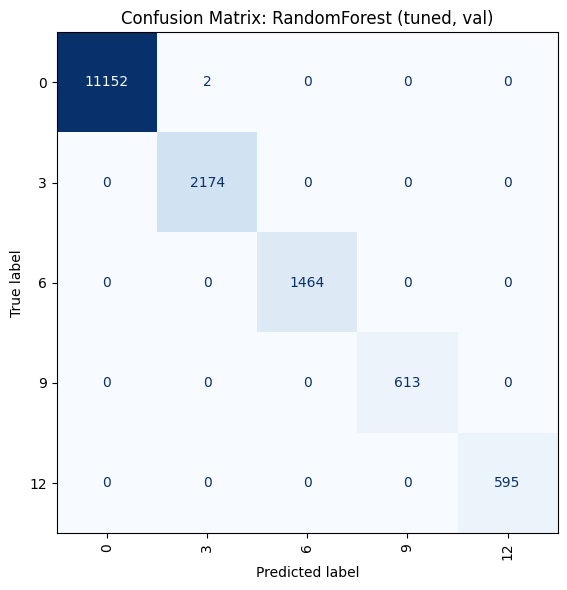

--- LogisticRegression (val) Evaluation ---
Accuracy: 0.99725
F1-weighted: 0.9972580144380788
F1-macro: 0.9969853416383796
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11154
           3       0.98      1.00      0.99      2174
           6       1.00      1.00      1.00      1464
           9       0.99      1.00      1.00       613
          12       1.00      1.00      1.00       595

    accuracy                           1.00     16000
   macro avg       0.99      1.00      1.00     16000
weighted avg       1.00      1.00      1.00     16000

ROC-AUC (OvR, macro): 0.9991338623790635


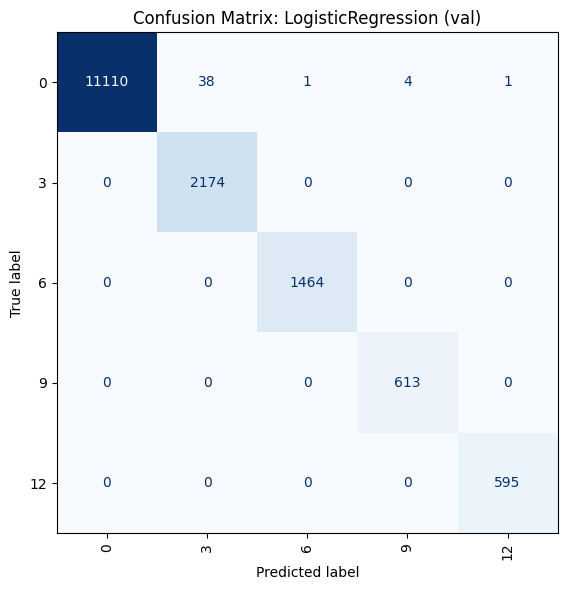

--- RandomForest (tuned, test) Evaluation ---
Accuracy: 0.9998
F1-weighted: 0.9998000591832386
F1-macro: 0.9998242488301539
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13943
           3       1.00      1.00      1.00      2718
           6       1.00      1.00      1.00      1830
           9       1.00      1.00      1.00       766
          12       1.00      1.00      1.00       743

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000

ROC-AUC (OvR, macro): 1.0


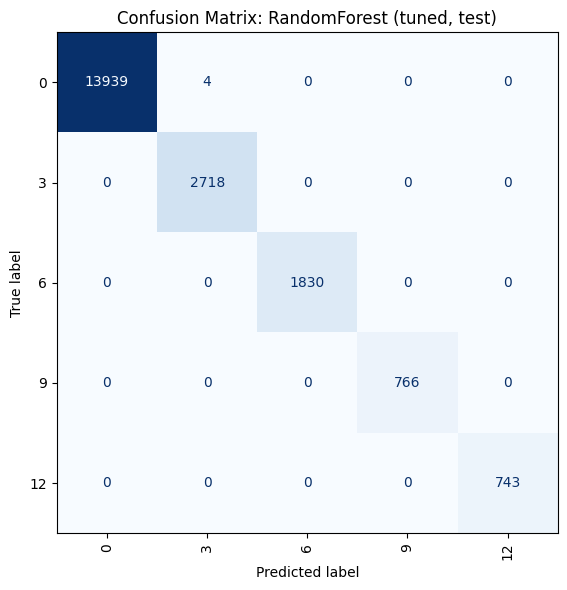

--- LogisticRegression (test) Evaluation ---
Accuracy: 0.997
F1-weighted: 0.9970093586083162
F1-macro: 0.9968502080736326
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13943
           3       0.98      1.00      0.99      2718
           6       1.00      1.00      1.00      1830
           9       1.00      1.00      1.00       766
          12       1.00      1.00      1.00       743

    accuracy                           1.00     20000
   macro avg       0.99      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000

ROC-AUC (OvR, macro): 0.9990476892521869


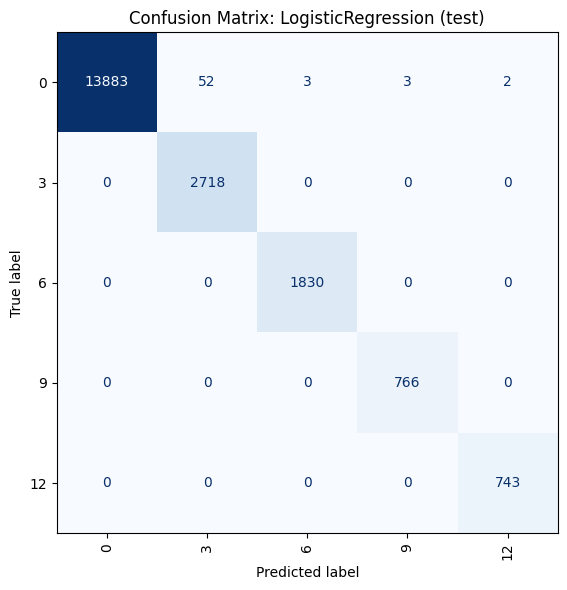


=== Summary Metrics ===


,accuracy,f1_weighted,f1_macro,roc_auc
name,,,,
"RandomForest (tuned, val)",0.999875,0.999875,0.999890,1.000000
LogisticRegression (val),0.997250,0.997258,0.996985,0.999134
"RandomForest (tuned, test)",0.999800,0.999800,0.999824,1.000000
LogisticRegression (test),0.997000,0.997009,0.996850,0.999048


Saving data artifacts to 'project_artifacts.pkl'...
Saving models locally...
Local save complete.
Backing up to Google Drive: /content/drive/MyDrive/idsprojectcsvs/
Saved project_artifacts.pkl to Drive
Saved best_rf_pipeline.pkl to Drive
Saved lr_pipeline.pkl to Drive

 DONE! All files are secured in Google Drive.


In [10]:

# 2. Drop tiny classes (UNCHANGED - LOOKS GOOD)

label_counts = train_df['label'].value_counts().sort_values()
smallest_k = 4
drop_labels = label_counts.head(smallest_k).index.tolist()
mask_keep = ~train_df['label'].isin(drop_labels)
train_df = train_df[mask_keep].reset_index(drop=True)


# 3. Prepare X / y


# 1. Define columns to drop
#  'label' is the target, 'timestamp' is a string/time object.
cols_to_drop = ['label', 'label_str', 'timestamp']

# add these just in case they appear in other days, 'errors=ignore' handles it if they are missing
cols_to_drop += ['flow_id', 'src_ip', 'dst_ip', 'source_ip', 'destination_ip']

print(f"Dropping non-numeric columns: {cols_to_drop}")
X = train_df.drop(columns=cols_to_drop, errors='ignore')
y = train_df['label']

# 2. Sampling (Memory Safety)
if MAX_TRAIN_ROWS is not None and len(X) > MAX_TRAIN_ROWS:
    print(f"Sampling training set to {MAX_TRAIN_ROWS} rows...")
    X, _, y, _ = train_test_split(
        X, y,
        train_size=MAX_TRAIN_ROWS,
        stratify=y,
        random_state=RANDOM_STATE
    )
    X.reset_index(drop=True, inplace=True)
    y.reset_index(drop=True, inplace=True)

print("Final X shape for splitting:", X.shape)

# 3. Numeric Conversion
# Now that 'timestamp' is gone, this should run without generating all NaNs
X = X.apply(pd.to_numeric, errors='coerce')

# 4. Fill NaNs and Infinities
# 'flow_byts/s' often contains Infinity in this dataset. We replace those with 0.
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(0) # Filling with 0 is often safer for Flow Stats than median, but median is also okay.


# 4. Stratified split into train/val/test

# First creating a (train+val) / test split on the original combined training days to simulate the actual run:
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)
# Then split trainval into train and validation in a stratified way:
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=VAL_SIZE, random_state=RANDOM_STATE, stratify=y_trainval
)

print("Shapes -> train:", X_train.shape, "val:", X_val.shape, "test:", X_test.shape)
print("Train class distribution:\n", y_train.value_counts(normalize=True))
print("Val class distribution:\n", y_val.value_counts(normalize=True))
print("Test class distribution:\n", y_test.value_counts(normalize=True))


# 5. Build pipeline: SMOTE + Scaler + Classifier
# We will tune RandomForest on og pipeline and compare to LogisticRegression baseline.

# Create SMOTE instance
smote = SMOTE(k_neighbors=SMOTE_K, random_state=RANDOM_STATE)

# scaler and classifiers
scaler = StandardScaler()
rf_clf = RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE, n_jobs=1)  # n_jobs=1 inside CV to avoid nested parallelism
lr_clf = LogisticRegression(max_iter=1000, class_weight='balanced', n_jobs=1, random_state=RANDOM_STATE)

# Imbalanced-learn pipeline: SMOTE must come BEFORE model but AFTER splitting. Scaling should be applied AFTER SMOTE.
#  (smote -> scaler -> clf)
pipe_rf = ImbPipeline(steps=[('smote', smote), ('scaler', scaler), ('clf', rf_clf)])
pipe_lr = ImbPipeline(steps=[('smote', smote), ('scaler', scaler), ('clf', lr_clf)])


# 6. Hyperparameter tuning (RandomizedSearchCV) for RF

param_dist = {
    'clf__n_estimators': [100, 150, 200],
    'clf__max_depth': [10, 15, 20, None],
    'clf__max_features': ['sqrt', 'log2', 0.3, 0.5],
    'clf__min_samples_split': [2, 4, 8],
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

rand_search = RandomizedSearchCV(
    pipe_rf,
    param_distributions=param_dist,
    n_iter=N_RANDOM_SEARCH,
    scoring='f1_weighted',   # optimize for weighted F1
    n_jobs=1,                # keep single job for inner cv to avoid overload
    cv=cv,
    random_state=RANDOM_STATE,
    verbose=1
)

print("Starting RandomizedSearchCV tuning for RandomForest")
t0 = time.time()
rand_search.fit(X_train, y_train)
t1 = time.time()

# Best RF pipeline
best_rf_pipeline = rand_search.best_estimator_


# 7. Train Logistic Regression baseline (with same pipeline but default params)

print("Training logistic regression baseline pipeline (may be faster)...")
t0 = time.time()
pipe_lr.fit(X_train, y_train)
t1 = time.time()


# 8. Evaluate classifiers on validation and test

def evaluate_and_report(pipe, X_eval, y_eval, label_encoder=None, name="Model"):
    y_pred = pipe.predict(X_eval)
    if hasattr(pipe, "predict_proba"):
        y_proba = pipe.predict_proba(X_eval)
    else:
        # pipeline with classifier has predict_proba
        y_proba = pipe.predict_proba(X_eval)

    acc = accuracy_score(y_eval, y_pred)
    f1_w = f1_score(y_eval, y_pred, average='weighted')
    f1_macro = f1_score(y_eval, y_pred, average='macro')
    report = classification_report(y_eval, y_pred)
    print(f"--- {name} Evaluation ---")
    print("Accuracy:", acc)
    print("F1-weighted:", f1_w)
    print("F1-macro:", f1_macro)
    print(report)

    # ROC-AUC OvR (multi-class). Need binarized y
    classes = np.unique(y_eval)
    try:
        y_bin = label_binarize(y_eval, classes=classes)
        # if y_proba columns mismatch classes (possible if some classes absent), align columns:
        if y_proba.shape[1] != y_bin.shape[1]:
            # try to build proba matrix for the classes found in y_eval
            # extract classes from the pipeline classifier
            clf_classes = pipe.named_steps['clf'].classes_
            # mapping: build proba with columns in 'classes'
            proba_aligned = np.zeros((y_proba.shape[0], len(classes)))
            for i, cls in enumerate(classes):
                if cls in clf_classes:
                    idx = list(clf_classes).index(cls)
                    proba_aligned[:, i] = y_proba[:, idx]
            y_proba = proba_aligned

        roc = roc_auc_score(y_bin, y_proba, average='macro', multi_class='ovr')
    except Exception as e:
        roc = np.nan
        print("ROC computation failed:", e)

    print("ROC-AUC (OvR, macro):", roc)

    # Confusion matrix plot
    cm = confusion_matrix(y_eval, y_pred, labels=classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    fig, ax = plt.subplots(figsize=(8,6))
    disp.plot(ax=ax, xticks_rotation=90, cmap='Blues', colorbar=False)
    plt.title(f"Confusion Matrix: {name}")
    plt.tight_layout()
    plt.show()

    return {
        'name': name, 'accuracy': acc, 'f1_weighted': f1_w, 'f1_macro': f1_macro, 'roc_auc': roc
    }

# Evaluate on validation
metrics_rf_val = evaluate_and_report(best_rf_pipeline, X_val, y_val, name="RandomForest (tuned, val)")
metrics_lr_val = evaluate_and_report(pipe_lr, X_val, y_val, name="LogisticRegression (val)")

# Evaluate on test
metrics_rf_test = evaluate_and_report(best_rf_pipeline, X_test, y_test, name="RandomForest (tuned, test)")
metrics_lr_test = evaluate_and_report(pipe_lr, X_test, y_test, name="LogisticRegression (test)")


import pandas as pd
import pickle
import shutil
import os
from IPython.display import display # Ensures display() works

# 10. Summary table of metrics
# (Ensure these metric variables exist from your previous evaluation step)
try:
    results = pd.DataFrame([
        metrics_rf_val, metrics_lr_val, metrics_rf_test, metrics_lr_test
    ])
    results.set_index('name', inplace=True)
    print("\n=== Summary Metrics ===")
    display(results)
except NameError:
    print(" Metrics variables not found.")

# 1. Define the artifacts im keeping
artifacts = {
    # The Data (Processed)
    "X_test": X_test,
    "y_test": y_test,

    # The Metadata
    "label_encoder": le,  # The encoder object used on y
    "feature_names": list(X_test.columns) if hasattr(X_test, "columns") else [],
    "class_mapping": dict(zip(le.transform(le.classes_), le.classes_)) # dictionary
}

# 2. Save the Artifacts Locally
print("Saving data artifacts to 'project_artifacts.pkl'...")
with open("project_artifacts.pkl", "wb") as f:
    pickle.dump(artifacts, f)

# 3. Save the Models Locally
print("Saving models locally...")
with open("best_rf_pipeline.pkl", "wb") as f:
    pickle.dump(best_rf_pipeline, f)
with open("lr_pipeline.pkl", "wb") as f:
    pickle.dump(pipe_lr, f)

print("Local save complete.")

# 4. Backup to Google Drive
drive_path = '/content/drive/MyDrive/idsprojectcsvs/'
print(f"Backing up to Google Drive: {drive_path}")

files = ["project_artifacts.pkl", "best_rf_pipeline.pkl", "lr_pipeline.pkl"]

for fn in files:
    try:
        source = f"/content/{fn}"
        destination = os.path.join(drive_path, fn)
        shutil.copy(source, destination)
        print(f"Saved {fn} to Drive")
    except Exception as e:
        print(f"Could not save {fn} to Drive: {e}")

print("\n DONE! All files are secured in Google Drive.")